In [5]:
import sys
sys.path.append('..')

import numpy as np
import os
from time import time
from collections import Counter
import random
from matplotlib import pyplot as plt

from lib.data_utils import shuffle
#from lib.config import data_dir

def mnist():
    fd = open(os.path.join('train-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trX = loaded[16:].reshape((60000,28*28)).astype(float)

    fd = open(os.path.join('train-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trY = loaded[8:].reshape((60000))

    fd = open(os.path.join('t10k-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teX = loaded[16:].reshape((10000,28*28)).astype(float)

    fd = open(os.path.join('t10k-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teY = loaded[8:].reshape((10000))
    
    trY = np.asarray(trY)
    teY = np.asarray(teY)

    return trX, teX, trY, teY

def mnist_with_valid_set():
    trX, teX, trY, teY = mnist()

    trX, trY = shuffle(trX, trY)
    vaX = trX[50000:]
    vaY = trY[50000:]
    trX = trX[:50000]
    trY = trY[:50000]

    return trX, vaX, teX, trY, vaY, teY

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '8180' (I am process '23532')
DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpnto5wd/265abc51f7c376c224983485238ff1a5.lib and object C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpnto5wd/265abc51f7c376c224983485238ff1a5.exp

Using gpu device 0: Quadro K2000 (CNMeM is disabled, cuDNN 5005)


In [6]:
#data_dir='/home/dcgan_code-master/mnist'
import theano
theano.config.floatX='float32'
theano.config.floatX

'float32'

In [22]:
trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()
import cv2
data2=np.zeros((1000,64*64))
trX=trX
%matplotlib inline
for i in range(1000):
    XXX=trX[i,:].reshape(28,28)
    temp=cv2.resize(XXX,(64,64))
    #temp[temp>=0.5]=1
    #temp[temp<=0.5]=0
    temp=temp.reshape(-1)
    data2[i,:]=np.round(temp/max(temp)*255.)

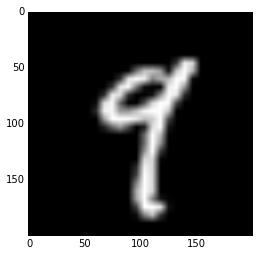

In [79]:
np.set_printoptions(threshold='nan')
plt.imshow(data2[0].reshape(200,200),'gray')
#plt.imshow(trX[0].reshape(28,28),'gray')

In [7]:
import numpy as np
import theano
import theano.tensor as tensor
from theano.tensor.signal.pool import pool_2d
from theano.tensor.nnet import conv2d

def conv( x, w, b=None ):
    s = int(np.floor(w.get_value().shape[-1]/2.))
    z = conv2d(x, w, border_mode='full')[:, :, s:-s, s:-s]
    if b is not None:
        z += b.dimshuffle('x', 0, 'x', 'x')
    
    return z
        
def max_pool( x, size, ignore_border=False ):
    return pool_2d( x, size, ignore_border=ignore_border )

def rectify( x ):
    return (x + abs(x)) / 2.0

def batchnorm( x, g=None, b=None, eps=1e-8 ):
    if x.ndim == 4:
        m = tensor.mean(x, axis=[0, 2, 3]).dimshuffle('x', 0, 'x', 'x')
        v = tensor.mean(tensor.sqr(x - m), 
                          axis=[0, 2, 3]).dimshuffle('x', 0, 'x', 'x')

        x = (x - m) / tensor.sqrt( v + eps )
        if g is not None and b is not None:
            x = x*g.dimshuffle('x', 0, 'x', 'x') + b.dimshuffle('x', 0, 'x', 'x')

    elif x.ndim == 2:
        m = tensor.mean(x, axis=0)
        v = tensor.mean(tensor.sqr(x - m), axis=0)

        x = (x - m) / tensor.sqrt( v + eps )
        if g is not None and b is not None:
            x = x*g + b

    return x

def depool( x, factor=2 ):
    """
    This code is from 
    https://gist.github.com/kastnerkyle/f3f67424adda343fef40
    """
    output_shape = [
        x.shape[1],
        x.shape[2]*factor,
        x.shape[3]*factor
    ]
    stride = x.shape[2]
    offset = x.shape[3]
    in_dim = stride * offset
    out_dim = in_dim * factor * factor

    upsamp_matrix = tensor.zeros((in_dim, out_dim))
    rows = tensor.arange(in_dim)
    cols = rows*factor + (rows/stride * factor * offset)
    upsamp_matrix = tensor.set_subtensor(upsamp_matrix[rows, cols], 1.)

    flat = tensor.reshape(x, (x.shape[0], output_shape[0], x.shape[2] * x.shape[3]))

    up_flat = tensor.dot(flat, upsamp_matrix)
    upsamp = tensor.reshape(up_flat, (x.shape[0], output_shape[0],
                                      output_shape[1], output_shape[2]))

    return upsamp

def full_conn( x, w, b=None ):
    return tensor.dot( x, w ) + b

def leaky_rectify( x, leak=0.2 ):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * x + f2 * abs(x) 

In [14]:
trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()
trX.shape

(50000L, 784L)

In [16]:
# only pick 0-9 for testing
import scipy.io as sio
WB=sio.loadmat('WB_test28_GAN.mat')['WB_test28_GAN']
WB.shape

(100L, 784L)

In [38]:
import scipy.io as sio
WB=sio.loadmat('WB_test28_4900.mat')['WB_small']
WB.shape

(4900L, 784L)

In [39]:
import sys
sys.path.append('..')

import os
import json
from time import time
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.externals import joblib

import theano
import theano.tensor as T
from theano.sandbox.cuda.dnn import dnn_conv

from lib import activations
from lib import updates
from lib import inits
from lib.vis import grayscale_grid_vis
from lib.rng import py_rng, np_rng
from lib.ops import batchnorm, conv_cond_concat, deconv, dropout
from lib.theano_utils import floatX, sharedX
from lib.data_utils import OneHot, shuffle, iter_data
from lib.metrics import nnc_score, nnd_score

trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()

#trX=data2
#trX = trX_test
#import scipy.io as sio
#WB=sio.loadmat('WB_test28_GAN.mat')['WB_test28_GAN']

trX=WB
vaX = floatX(vaX[0:1000])/255.

k = 1             # # of discrim updates for each gen update
l2 = 2.5e-5       # l2 weight decay
b1 = 0.5          # momentum term of adam
nc = 1            # # of channels in image
ny = 10           # # of classes
nbatch = 700      # # of examples in batch
npx = 28          # # of pixels width/height of images
nz = 100          # # of dim for Z
ngfc = 1024       # # of gen units for fully connected layers
ndfc = 1024       # # of discrim units for fully connected layers
ngf = 64          # # of gen filters in first conv layer
ndf = 64          # # of discrim filters in first conv layer
nx = npx*npx*nc   # # of dimensions in X
niter = 100       # # of iter at starting learning rate
niter_decay = 100 # # of iter to linearly decay learning rate to zero
lr = 0.0002       # initial learning rate for adam
ntrain, nval, ntest = len(trX), len(vaX), len(teX)

def transform(X):
    return (floatX(X)/1.).reshape(-1, nc, npx, npx)

def inverse_transform(X):
    X = X.reshape(-1, npx, npx)
    return X

relu = activations.Rectify()
sigmoid = activations.Sigmoid()
lrelu = activations.LeakyRectify()
bce = T.nnet.binary_crossentropy

gifn = inits.Normal(scale=0.02)
difn = inits.Normal(scale=0.02)
gain_ifn = inits.Normal(loc=1., scale=0.02)
bias_ifn = inits.Constant(c=0.)


gw  = gifn((nz, ngfc), 'gw')
gg = gain_ifn((ngfc), 'gg')
gb = bias_ifn((ngfc), 'gb')

gw2 = gifn((ngfc, ngf*2*7*7), 'gw2')
gg2 = gain_ifn((ngf*2*7*7), 'gg2')
gb2 = bias_ifn((ngf*2*7*7), 'gb2')

gw3 = gifn((ngf*2, ngf, 5, 5), 'gw3')
gg3 = gain_ifn((ngf), 'gg3')
gb3 = bias_ifn((ngf), 'gb3')

# gw4 = gifn((ngf*2, ngf, 5, 5), 'gw4')
# gg4 = gain_ifn((ngf), 'gg4')
# gb4 = bias_ifn((ngf), 'gb4')

gwx = gifn((ngf, nc, 5, 5), 'gwx')

dw  = difn((ndf, nc, 5, 5), 'dw')
# dg = gain_ifn((ndf), 'dg')
# db = bias_ifn((ndf), 'db')

dw2 = difn((ndf*2, ndf, 5, 5), 'dw2')
dg2 = gain_ifn((ndf*2), 'dg2')
db2 = bias_ifn((ndf*2), 'db2')

dw3 = difn((ndf*2*7*7, ndfc), 'dw3')
dg3 = gain_ifn((ndfc), 'dg3')
db3 = bias_ifn((ndfc), 'db3')

dwy = difn((ndfc, 1), 'dwy')

gen_params = [gw, gg, gb, gw2, gg2, gb2, gw3, gg3, gb3, gwx]
discrim_params = [dw,dw2,dg2,db2, dw3,dg3,db3, dwy]

def gen(Z, w, gg, gb, w2, gg2, gb2, w3, gg3, gb3, wx):
    h = relu(batchnorm(T.dot(Z, w),g=gg,b=gb))
    h2 = relu(batchnorm(T.dot(h, w2),g=gg2,b=gb2))
    h2 = h2.reshape((h2.shape[0], ngf*2, 7, 7))
    h3 = relu(batchnorm(deconv(h2, w3, subsample=(2, 2), border_mode=(2, 2)),g=gg3,b=gb3))
    #h4 = relu(batchnorm(deconv(h3, w4, subsample=(2, 2), border_mode=(2, 2)),g=gg4,b=gb4))
    x = sigmoid(deconv(h3, wx, subsample=(2, 2), border_mode=(2, 2)))
    return x

def discrim(X, w, w2, dg2, db2, w3, dg3, db3, wy):
    h = lrelu(dnn_conv(X, w, subsample=(2, 2), border_mode=(2, 2)))
    h2 = lrelu(batchnorm(dnn_conv(h, w2, subsample=(2, 2), border_mode=(2, 2)),g=dg2,b=db2))
    h2 = T.flatten(h2, 2)
    h3 = lrelu(batchnorm(T.dot(h2, w3), g=dg3,b=db3))
    y = sigmoid(T.dot(h3, wy))
    return y

X = T.tensor4()
Z = T.matrix()

gX = gen(Z, *gen_params)

p_real = discrim(X, *discrim_params)
p_gen = discrim(gX, *discrim_params)

d_cost_real = bce(p_real, T.ones(p_real.shape)).mean()
d_cost_gen = bce(p_gen, T.zeros(p_gen.shape)).mean()
g_cost_d = bce(p_gen, T.ones(p_gen.shape)).mean()

d_cost = d_cost_real + d_cost_gen
g_cost = g_cost_d

cost = [g_cost, d_cost, g_cost_d, d_cost_real, d_cost_gen]

lrt = sharedX(lr)
d_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
g_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
d_updates = d_updater(discrim_params, d_cost)
g_updates = g_updater(gen_params, g_cost)
updates = d_updates + g_updates

print 'COMPILING'
t = time()
_train_g = theano.function([X, Z], cost, updates=g_updates)
_train_d = theano.function([X, Z], cost, updates=d_updates)
_gen = theano.function([Z], gX)
print '%.2f seconds to compile theano functions'%(time()-t)

sample_zmb = floatX(np_rng.uniform(-1., 1., size=(200, nz)))


n_updates = 0
n_check = 0
n_epochs = 0
n_updates = 0
n_examples = 0
t = time()
for epoch in range(1, niter+niter_decay+1):
    trX= shuffle(trX)
    for imb in tqdm(iter_data(trX, size=nbatch), total=ntrain/nbatch):
        imb = transform(imb)
        #ymb = floatX(OneHot(ymb, ny))
        zmb = floatX(np_rng.uniform(-1., 1., size=(len(imb), nz)))
        if n_updates % (k+1) == 0:
            cost = _train_g(imb, zmb)
        else:
            cost = _train_d(imb, zmb)
        n_updates += 1
        n_examples += len(imb)
    #if (epoch-1) % 5 == 0:
    g_cost = float(cost[0])
    d_cost = float(cost[1])
    print g_cost, d_cost

COMPILING
26.87 seconds to compile theano functions


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.01s/it]


0.697764515877 1.39569056034


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.03s/it]


0.710438489914 1.38265061378


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.01s/it]


0.72303879261 1.35899233818


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.03s/it]


0.724296450615 1.34719514847


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.01s/it]


0.735518276691 1.32986032963


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.03s/it]


0.743102431297 1.31544280052


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.01s/it]


0.754701375961 1.29348254204


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.04s/it]


0.764235854149 1.27815389633


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.01s/it]


0.779671609402 1.25718545914


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.03s/it]


0.786950170994 1.24355137348


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.01s/it]


0.809599459171 1.21565937996


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.03s/it]


0.817382276058 1.19367051125


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.01s/it]


0.846248447895 1.16178977489


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.03s/it]


0.858867168427 1.14377582073


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.01s/it]


0.893105387688 1.14754486084


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.03s/it]


0.906738638878 1.10585045815


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.01s/it]


0.924742758274 1.06530058384


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.03s/it]


0.934944570065 1.03525435925


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.01s/it]


0.97152030468 1.01976823807


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.03s/it]


0.997805356979 1.07264637947


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.01s/it]


1.00097346306 0.985542058945


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.03s/it]


1.02720487118 0.969905257225


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.01s/it]


1.06758034229 0.941004276276


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.03s/it]


1.0635676384 0.923630237579


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.01s/it]


1.09535169601 0.869198918343


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.03s/it]


1.11370098591 0.8542958498


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.00s/it]


1.15418291092 0.866703212261


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.03s/it]


1.13804388046 0.876643180847


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.01s/it]


1.17432582378 0.800073444843


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.03s/it]


1.21266543865 0.776595473289


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.00s/it]


1.22261297703 0.733837246895


100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.04s/it]


1.252643466 0.742908716202


  0%|                                                    | 0/7 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [52]:
def gen(Z, w, gg, gb, w2, gg2, gb2, w3, gg3, gb3, wx):
    h = relu(batchnorm(T.dot(Z, w),g=gg,b=gb))
    h2 = relu(batchnorm(T.dot(h, w2),g=gg2,b=gb2))
    h2 = h2.reshape((h2.shape[0], ngf*2, 16, 16))
    h3 = relu(batchnorm(deconv(h2, w3, subsample=(2, 2), border_mode=(2, 2)),g=gg3,b=gb3))
    x = sigmoid(deconv(h3, wx, subsample=(2, 2), border_mode=(2, 2)))
    return x

X = T.tensor4()
Z = T.matrix()

gX = gen(Z, *gen_params)

_train_g = theano.function([Z], gX)

zmb = floatX(np_rng.uniform(-1., 1., size=(len(imb), nz)))
cost = _train_g(zmb)


In [55]:
for epoch in range(1, 1000):
    trX= shuffle(trX)
    for imb in tqdm(iter_data(trX, size=nbatch), total=ntrain/nbatch):
        imb = transform(imb)
        #ymb = floatX(OneHot(ymb, ny))
        zmb = floatX(np_rng.uniform(-1., 1., size=(len(imb), nz)))
        if n_updates % (k+1) == 0:
            cost = _train_g(imb, zmb)
        else:
            cost = _train_d(imb, zmb)
        n_updates += 1
        n_examples += len(imb)
    if (epoch-1) % 5 == 0:
        g_cost = float(cost[0])
        d_cost = float(cost[1])

100%|████████████████████████████████████████████| 7/7 [00:07<00:00,  1.02s/it]


In [32]:
print g_cost, d_cost

5.4889330864 0.168628767133


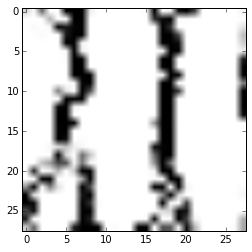

In [56]:
%matplotlib inline
sample_zmb = floatX(np_rng.uniform(-1., 1., size=(100, nz)))
samples = np.asarray(_gen(sample_zmb))
plt.imshow(samples[0].reshape(28,28),'gray')

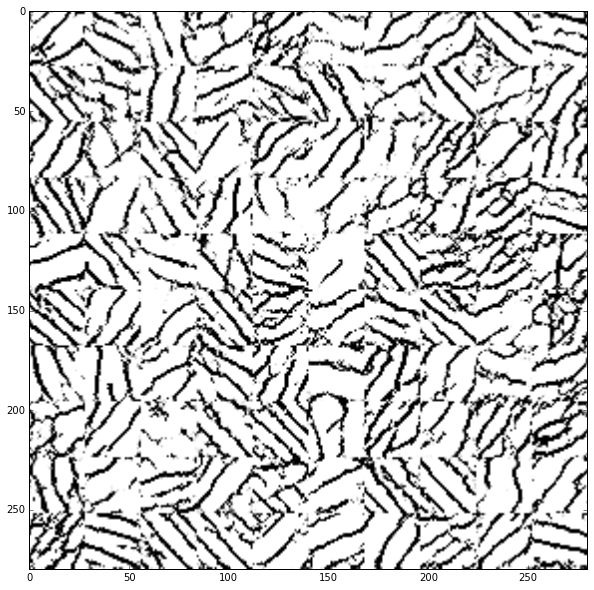

In [58]:
n = 10  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np_rng.uniform(-1., 1., size=(100, nz))
        z_sample=z_sample.astype(np.float32)
        x_decoded = _gen(z_sample)[0]
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()

(array([ 573.,   10.,   10.,    8.,   16.,    7.,    5.,   13.,   14.,  128.]),
 array([  4.62138674e-19,   9.99975324e-02,   1.99995065e-01,
          2.99992597e-01,   3.99990129e-01,   4.99987662e-01,
          5.99985194e-01,   6.99982727e-01,   7.99980259e-01,
          8.99977791e-01,   9.99975324e-01]),
 <a list of 10 Patch objects>)

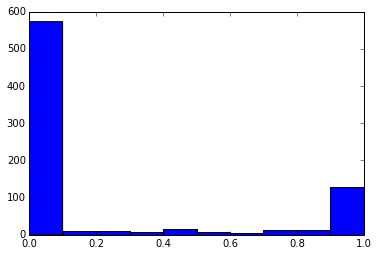

In [128]:
plt.hist(x_decoded.reshape(-1))